In [ ]:
#@title
import numpy as np
import jax.numpy as jnp
import jax
np.random.seed(1)

# RUNNING SHAPE ASSUMPTIONS
# P.shape = (n_states, n_actions, n_states)
# r.shape = (n_states, n_actions)
# pi.shape = (n_states, n_actions) ## in certain state, the probability that policy pi leads to certain action

# Calculating value functions
def get_P_pi(P, pi):
    return jnp.sum(P * jnp.expand_dims(pi, axis = -1), axis = 1)

def get_V(P, r, gamma, pi):
    P_pi = get_P_pi(P, pi)
    r_pi = jnp.sum(r * pi, axis = -1)
    # v is the vector such that (I - gamma P_pi) v = r_pi
    return jnp.linalg.solve(jnp.eye(pi.shape[0]) - gamma * P_pi, r_pi)

def get_Q(P, r, gamma, pi):
    n_states = P.shape[0]
    V = get_V(P, r, gamma, pi)
    Vp =  jnp.sum(P * V.reshape((1, 1, n_states)), axis = -1)
    return r + gamma * Vp

def get_soft_V(P, r, gamma, pi, tau):
    P_pi = get_P_pi(P, pi)
    r_pi = np.sum(r * pi, axis = -1) - tau * np.sum(pi * np.log(pi), axis = 1)
    return jnp.linalg.solve(jnp.eye(pi.shape[0]) - gamma * P_pi, r_pi)

def get_soft_Q(P, r, gamma, pi, tau):
    n_states = P.shape[0]
    V = get_soft_V(P, r, gamma, pi, tau)
    Vp =  jnp.sum(P * V.reshape((1, 1, n_states)), axis = -1)
    return r + gamma * Vp


# Misc RL procedures
def value_iteration(P, r, gamma, V, iters = 1):
    n_states = P.shape[0]
    res = V
    for _ in range(iters):
        Vp =  jnp.sum(P * res.reshape((1, 1, n_states)), axis = -1)
        res = jnp.max(r + gamma * Vp, axis = -1)
        assert jnp.shape(res)[0] == n_states
        assert len(res[res != res]) == 0
    return res

def get_optimal_V(P, r, gamma, iters = int(1e5)):
    return value_iteration(P, r, gamma, np.zeros(P.shape[0]), iters)

def action_value_iteration(P, r, gamma, Q, iters = 1):
    n_states = P.shape[0]
    n_actions = r.shape[1]
    res = Q
    for _ in range(iters):
        max_Q = jnp.max(res, axis = -1).reshape((1, 1, n_states))
        res = r + gamma * jnp.sum(max_Q * P, axis = -1)
        assert res.shape == (n_states, n_actions), res.shape
    return res

def get_optimal_Q(P, r, gamma, iters = int(1e5)):
    n_states = P.shape[0]
    n_actions = r.shape[1]
    Q = np.zeros((n_states, n_actions))
    return action_value_iteration(P, r, gamma, Q, iters = iters)

def get_greedy_pi(Q):
    n_states = Q.shape[0]
    n_actions = Q.shape[1]
    # extract greedy policy from Q
    max_actions =  jnp.argmax(Q, axis = -1)
    pi = np.zeros((n_states, n_actions))
    for i in range(n_states):
        pi[i, max_actions[i]] = 1
    return pi


def get_d_pi(P, gamma, pi, rho):
    # d_pi = (1 - gamma) (I - \gamma P.T)^{-1} \rho
    n_states = P.shape[0]
    P_pi = get_P_pi(P, pi)
    # d_pi is the vector such that (I - \gamma P_pi.T) d_pi = (1 - gamma) * \rho
    return jnp.linalg.solve(jnp.eye(n_states) - gamma * P_pi.T, (1 - gamma) * rho)

In [ ]:
def build_low_rank_mdp(d, p, K, L, R=1.0, epsilon=0.15):
    P=np.zeros((2*K*d+2,2*L,2*K*d+2))
    r=np.zeros((2*K*d+2,2*L))
    for i in range(d-1):
        for j in range(K):
            for k in range(L):
                P[i*K+j,k,i*K:(i+1)*K]=(1-p)*np.random.dirichlet(np.ones(K),size=1)
                P[i*K+j,k,(i+1)*K:(i+2)*K]=p*np.random.dirichlet(np.ones(K),size=1)
                P[i*K+j,L+k,(d+i)*K:(d+i+1)*K]=(1-p)*np.random.dirichlet(np.ones(K),size=1)
                P[i*K+j,L+k,(d+i+1)*K:(d+i+2)*K]=p*np.random.dirichlet(np.ones(K),size=1)
                P[(d+i)*K+j,k,(d+i)*K:(d+i+1)*K]=(1-p)*np.random.dirichlet(np.ones(K),size=1)
                P[(d+i)*K+j,k,(d+i+1)*K:(d+i+2)*K]=p*np.random.dirichlet(np.ones(K),size=1)
                P[(d+i)*K+j,L+k,(d+i)*K:(d+i+1)*K]=(1-p)*np.random.dirichlet(np.ones(K),size=1)
                P[(d+i)*K+j,L+k,(d+i+1)*K:(d+i+2)*K]=p*np.random.dirichlet(np.ones(K),size=1)
    for j in range(K):
        P[(d-1)*K+j,:,2*K*d]=0.5+epsilon
        P[(d-1)*K+j,:,2*K*d+1]=0.5-epsilon
        P[(2*d-1)*K+j,:,2*K*d]=0.5
        P[(2*d-1)*K+j,:,2*K*d+1]=0.5
    P[2*K*d,:,2*K*d+1]=1
    P[2*K*d+1,:,2*K*d+1]=1
    r[2*K*d,:]=R
    return P, r

d=10
p=0.95
K=10
L=10
R=100.0
epsilon=0.40
gamma=2*d/(2*d+1)
P,r=build_low_rank_mdp(d,p,K,L,R,epsilon)
rho=np.zeros(2*K*d+2)
#rho[:K]=np.random.dirichlet(np.ones(K),size=1)
rho[:K]=1.0/K

In [ ]:
Q_approx=np.zeros((2*d+2,2))
Q_approx[2*d,:]=np.array([R,R])
Q_approx[2*d-1,:]=np.array([0.5*gamma*R,0.5*gamma*R])
for i in range(2*d-2,d-1,-1):
    Q_approx[i,:]=Q_approx[i+1,:]*p*gamma/(1-gamma+p*gamma)
Q_approx[d-1,:]=np.array([(0.5+epsilon)*gamma*R,(0.5-epsilon)*gamma*R])
for i in range(d-2,-1,-1):
    Q_approx[i,0]=Q_approx[i+1,0]*p*gamma/(1-gamma+p*gamma)
    Q_approx[i,1]=(1-p)*gamma*Q_approx[i+d,0]+p*gamma*Q_approx[i+d+1,0]

In [ ]:
phi=np.zeros((2*K*d+2,2*L,2*d+2,2))
for i in range(d):
    for j in range(2):
        for k in range(K):
            for l in range(L):
                phi[i*K+k,j*L+l,i,j]=1
                phi[(i+d)*K+k,j*L+l,i+d,j]=1
for i in range(2):
    for j in range(L):
        phi[2*K*d,i*L+j,2*d,i]=1
        phi[2*K*d+1,i*L+j,2*d+1,i]=1

In [ ]:
def nabula_log_pi(s,a,theta,phi):
    S,A,_,_=phi.shape
    ret=phi[s][a]
    val=np.zeros(A)
    for action in range(A):
        val[action]=np.exp(np.sum(phi[s][action]*theta))
    val=val/np.sum(val)
    for action in range(A):
        ret=ret-val[action]*phi[s][action]
    return ret

In [ ]:
def get_pi(theta,phi,S,A):
    pi=np.zeros((S,A))
    for s in range(S):
        for a in range(A):
            pi[s][a]=np.exp(np.sum(phi[s][a]*theta))
    for s in range(S):
        pi[s]=pi[s]/np.sum(pi[s])
    return pi

In [ ]:
def fisher_information_matrix(theta,phi,S,A,P,gamma,rho):
    _,_,S_lr,A_lr=phi.shape
    ret=np.zeros((S_lr,S_lr))
    pi=get_pi(theta,phi,S,A)
    #print("pi=",pi)
    d_pi=get_d_pi(P, gamma, pi, rho)
    #print("dpi=",d_pi)
    for s in range(S):
        for a in range(A):
            grad=nabula_log_pi(s,a,theta,phi)
            #print("grad=",grad)
            mat=grad@grad.T
            #mat=grad*grad
            ret=ret+d_pi[s]*pi[s,a]*mat
    return ret

In [ ]:
import jax

import matplotlib
from matplotlib import pyplot as plt

# make fonts of pyplot bigger
matplotlib.rcParams.update({'font.size': 10})

@jax.jit
def true_gradient(P, r, gamma, theta, phi, rho):
    pi=jax.nn.softmax(np.sum(np.sum(theta*phi,axis=-1),axis=-1),axis=1)
    #print("pi:",pi.shape)
    d_pi = jax.lax.stop_gradient(get_d_pi(P, gamma, pi, rho))
    #print("d_pi:",d_pi.shape)
    qpi = jax.lax.stop_gradient(get_Q(P, r, gamma, pi))
    #print("q_pi:",qpi.shape)
    grad = jax.grad(
        lambda theta: np.sum(d_pi * np.sum(qpi * jax.nn.softmax(np.sum(np.sum(theta*phi,axis=-1),axis=-1),axis=1), axis = 1))
    )(theta)
    #print("grad:",grad.shape)
    return grad / (1 - gamma)

In [ ]:
def policy_objective(P, r, gamma, pi, rho):
  v_pi = get_V(P, r, gamma, pi)
  return jnp.sum(v_pi * rho)

In [ ]:
def run_policy_gradient(P, r, gamma, theta, phi, rho, mu, lr, T, callback = None):
  performance = np.zeros(T)
  surrogate_performance = np.zeros(T)
  S,A,_,_=phi.shape
  # run policy gradient for T timesteps, updating at every time step
  for t in range(T):
    print(t)
    pi=get_pi(theta,phi,S,A)
    print(pi)
    #print(pi.shape)
    # record performance with respect to the original objective V^\theta(s_0)
    performance[t] = policy_objective(P, r, gamma, pi, rho)

    # record performance with respect to the surrogate objective J_\mu(\pi)
    surrogate_performance[t] = policy_objective(P, r, gamma, pi, mu)

    # callback for recording data
    #if callback is not None:
    #  callback(P, r, gamma, logits, rho, mu, pi, t)

    # take a gradient step with respect to the surrogate objective J_\mu(\pi)
    #print("grad")
    #print(true_gradient(P, r, gamma, theta, phi, mu))
    #print(true_gradient(P, r, gamma, theta, phi, mu).shape)
    #print(fisher_information_matrix(theta,phi,S,A,P,gamma,rho))
    #print(fisher_information_matrix(theta,phi,S,A,P,gamma,rho).shape)
    FIM=fisher_information_matrix(theta,phi,S,A,P,gamma,rho)
    print("FIM=",FIM)
    #if FIM<1e-6:
    #    T=t+1
    #    return (performance, surrogate_performance,T)
    theta = theta + lr* np.linalg.pinv (FIM) @ true_gradient(P, r, gamma, theta, phi, mu)
  return (performance, surrogate_performance,T)

In [ ]:
theta=np.random.rand(2*d+2,2)
#theta=np.zeros((2*d+2,2))
#theta=np.zeros((8,2))
#theta[:d,0:1]=np.ones((d,1))
#theta[d:,:]=0.5*np.ones((d+2,2))

In [ ]:
perf1,perf2,T=run_policy_gradient(P,r,gamma,theta,phi,rho,rho,0.01,5)

0
[[0.04161124 0.04161124 0.04161124 ... 0.05838876 0.05838876 0.05838876]
 [0.04161124 0.04161124 0.04161124 ... 0.05838876 0.05838876 0.05838876]
 [0.04161124 0.04161124 0.04161124 ... 0.05838876 0.05838876 0.05838876]
 ...
 [0.06835419 0.06835419 0.06835419 ... 0.03164581 0.03164581 0.03164581]
 [0.03956885 0.03956885 0.03956885 ... 0.06043115 0.06043115 0.06043115]
 [0.05279129 0.05279129 0.05279129 ... 0.04720871 0.04720871 0.04720871]]
FIM= [[2.36071218e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.99451210e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.0

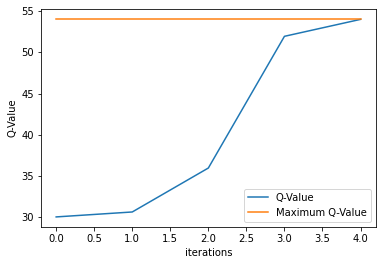

In [ ]:
import matplotlib.pyplot as plt
plt.plot(perf1[:T],label='Q-Value')
plt.plot(Q_approx[0][0]*np.ones(perf1[:T].shape),label='Maximum Q-Value')
plt.xlabel('iterations')
plt.ylabel('Q-Value')
plt.legend()
plt.show()